 #### Coded by: Vikranth

In [1]:
import pandas as pd
from sklearn import ensemble
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib notebook

(179962, 15)
(69818, 3)
(69818, 15)


<IPython.core.display.Javascript object>


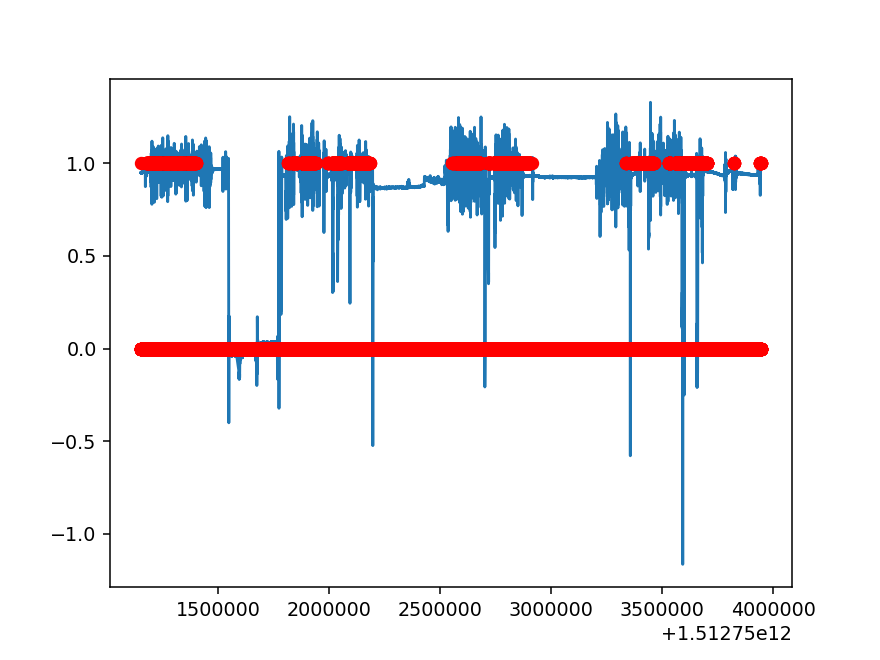

<IPython.core.display.Javascript object>


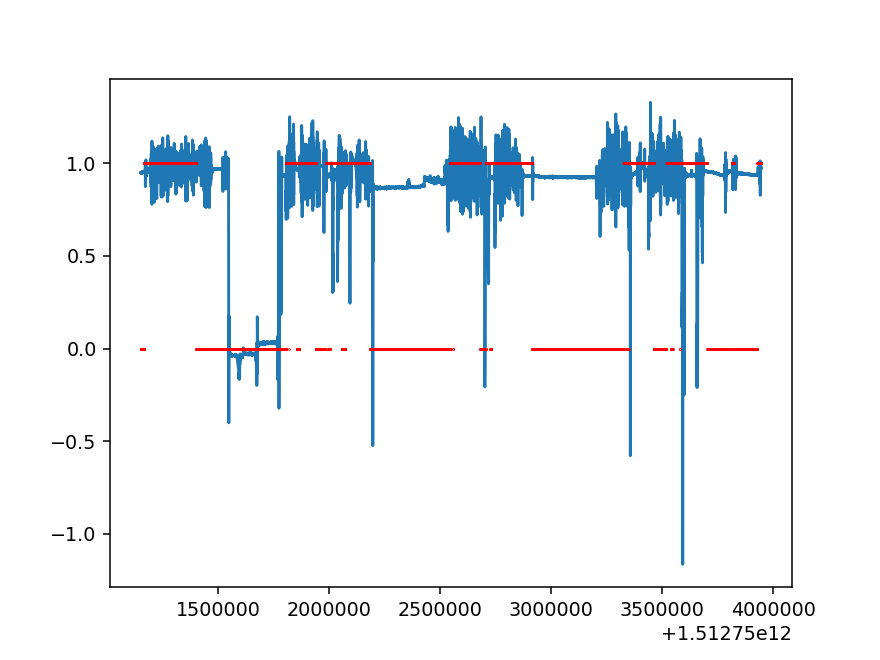

In [2]:
participant_1 = pd.read_pickle('Participant_3.pkl')
#print(participant_1)
labels_1 = np.load('Participant_3_label.npy')
#print(labels_1)

start_time = labels_1[0,0]
end_time = labels_1[-1,0]

dataset = np.copy(participant_1.values)
print(dataset.shape)
print(labels_1.shape)

delta = 40
dataset = dataset[dataset[:,0] >= start_time,:]
dataset = dataset[dataset[:,0] < end_time + delta,:]
print(dataset.shape)

plt.figure()
plt.plot(dataset[:,0],dataset[:,3])
plt.show()
plt.plot(dataset[:,0],labels_1[:,2],'ro')
plt.show()

type_window = 10000
k = int(type_window/delta)
l = len(labels_1)
typing_labels = np.zeros((l,1))
for i in range(0,l):
    if i<(l-k):
        typing_labels[i] = np.amax(labels_1[i:i+k,2])
    else:
        typing_labels[i] = np.amax(labels_1[i:,2])
#print(typing_labels)

plt.figure()
plt.plot(dataset[:,0],dataset[:,3])
plt.show()
plt.plot(dataset[:,0],typing_labels,'r.', ms = 0.1)
plt.show()

Counter({0.0: 66958, 1.0: 2135, 2.0: 725})
(66958, 1)
(66958, 15)


<IPython.core.display.Javascript object>


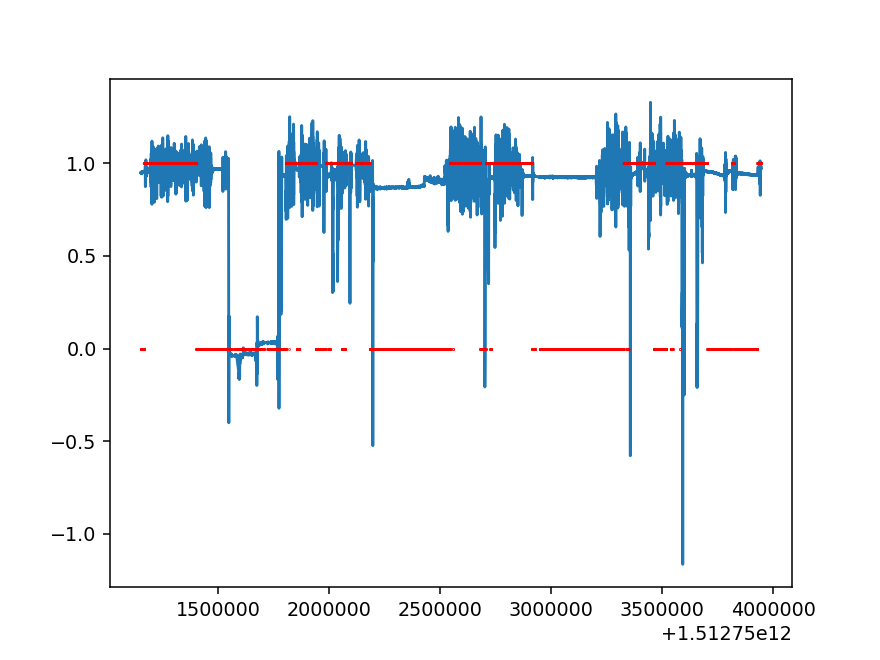

In [3]:
# Remove Missing Data:
missing_1 = dataset[:,13] + dataset[:,14]
print(Counter(missing_1))

dataset = dataset[np.where(missing_1 == 0)]
typing_labels = typing_labels[np.where(missing_1 == 0)]

print(typing_labels.shape)
print(dataset.shape)

plt.figure()
plt.plot(dataset[:,0],dataset[:,3])
plt.show()
plt.plot(dataset[:,0],typing_labels,'r.', ms = 0.1)
plt.show()

In [70]:
dataset_cp = np.copy(dataset[:,1:13])

n_samples, d = dataset_cp.shape
window = 20
stride = 5

data_slide = np.zeros((int((n_samples-window)/stride)+1,window,d))
typing_labels_cp = np.zeros((int((n_samples-window)/stride)+1,1))
time_t = np.zeros((int((n_samples-window)/stride)+1,1))
k=0
for i in range(0,n_samples-window,stride): #400ms
    data_slide[k,:,:] = dataset_cp[i:i+window,:]
    typing_labels_cp[k] = np.amax(typing_labels[i:i+window])
    time_t[k] = dataset[i,0]
    k=k+1
    
print (data_slide.shape)
print(typing_labels_cp.shape)
print(time_t.shape)

(13388, 20, 12)
(13388, 1)
(13388, 1)


In [71]:
print("%f" %time_t[-1])

1512753943498.000000


In [26]:
import numpy as np
import scipy.io

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Dropout, Flatten
from keras.layers.core import Permute, Reshape
from keras import backend as K
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

Using TensorFlow backend.


In [27]:
z = 0
X_train0 = data_slide[:z]
Y_train = typing_labels_cp[0:z].reshape(-1).astype(np.uint8)
X_test0 = data_slide[z:]
Y_test = typing_labels_cp[z:]
print(np.shape(X_train0))
print(np.shape(Y_train))
print(np.shape(X_test0))
print(np.shape(Y_test))

(0, 20, 12)
(0,)
(13388, 20, 12)
(13388, 1)


In [28]:
num_classes = 2
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)

In [29]:
def _data_reshaping(X_tr, X_va, network_type):
    _, win_len, dim = X_tr.shape
    print(network_type)
    if network_type=='CNN' or network_type=='ConvLSTM':
        
        # make it into (frame_number, dimension, window_size, channel=1) for convNet
        X_tr = np.swapaxes(X_tr,1,2)
        X_va = np.swapaxes(X_va,1,2)

        X_tr = np.reshape(X_tr, (-1, dim, win_len, 1))
        X_va = np.reshape(X_va, (-1, dim, win_len, 1))
        
    if network_type=='MLP':
        print('MLP...')
        X_tr = np.reshape(X_tr, (-1, dim*win_len))
        X_va = np.reshape(X_va, (-1, dim*win_len))
    
    return X_tr, X_va


In [30]:
model = load_model('Typing_Detection\Convbn_LSTM_100.h5')

In [31]:
batch_size = 1024
num_feat_map = 16
num_hidden_mlp = 128
num_hidden_lstm = 64

#network_type = 'CNN'
network_type = 'ConvLSTM'
#network_type = 'LSTM'
#network_type = 'MLP'
_, win_len, dim = X_train0.shape
print(win_len)
print(dim)

X_train, X_test = _data_reshaping(X_train0, X_test0, network_type)


20
12
ConvLSTM


In [32]:
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(Y_test, axis=1)
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)
class_wise_f1 = np.round(f1_score(y_true, y_pred, average=None)*100)*0.01
print('the mean-f1 score: {:.2f}'.format(np.mean(class_wise_f1)))


[[6612  927]
 [2265 3584]]
the mean-f1 score: 0.75


<IPython.core.display.Javascript object>


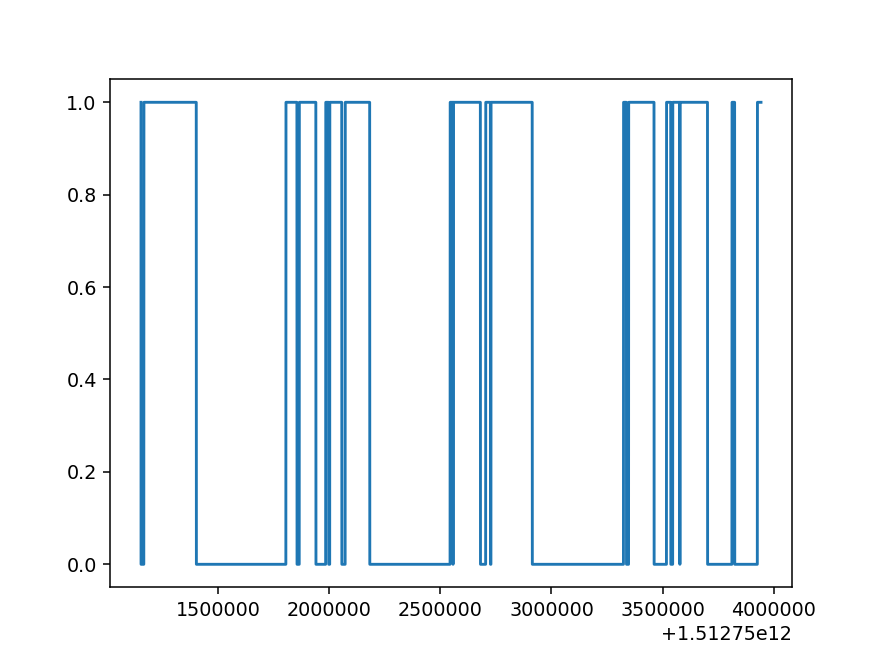

<IPython.core.display.Javascript object>


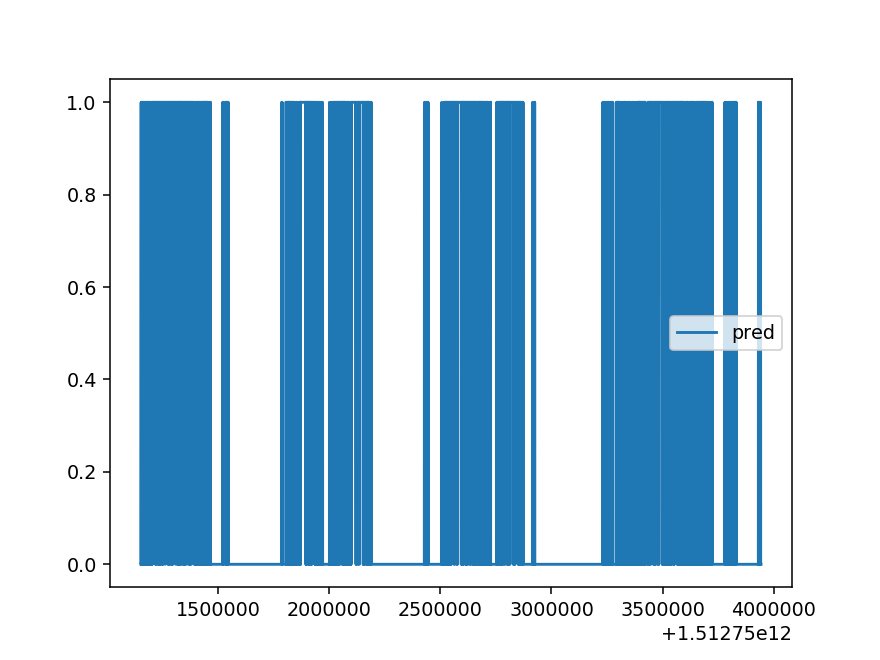

In [72]:
plt.figure()
plt.plot(time_t, y_true, label="true")
plt.figure()
plt.plot(time_t,y_pred, label="pred")

#plt.plot(typing_labels_cp[60000:], label="label")

plt.legend()
plt.show()

In [73]:
indices_type = np.where(y_pred == 1)[0]
time_type = time_t[indices_type]
print(indices_type.shape)

(4511,)


In [74]:
Counter(np.diff(time_type[:,0]))

Counter({200.0: 3998,
         400.0: 156,
         600.0: 67,
         800.0: 40,
         1000.0: 45,
         1200.0: 23,
         1400.0: 26,
         1600.0: 15,
         1800.0: 16,
         2000.0: 14,
         2200.0: 11,
         2400.0: 7,
         2600.0: 9,
         2800.0: 9,
         3000.0: 4,
         3200.0: 2,
         3400.0: 3,
         3800.0: 9,
         4000.0: 3,
         4200.0: 1,
         4600.0: 2,
         4800.0: 3,
         5000.0: 3,
         5200.0: 2,
         5400.0: 2,
         5600.0: 1,
         5800.0: 2,
         6000.0: 2,
         6200.0: 1,
         6400.0: 3,
         7600.0: 5,
         7800.0: 2,
         8400.0: 1,
         8800.0: 1,
         9000.0: 1,
         9600.0: 2,
         10000.0: 1,
         10400.0: 1,
         10600.0: 1,
         12000.0: 1,
         12440.0: 1,
         12960.0: 1,
         16200.0: 1,
         16400.0: 1,
         19880.0: 1,
         28200.0: 1,
         31200.0: 1,
         42600.0: 1,
         55600.0: 

In [83]:
pred_l = len(y_pred)
ind_l = len(indices_type)
smooth_labels_3 = np.zeros((pred_l,1))
s = 0
start_time = []
end_time = []

for i in range(0,ind_l-1):
    if(s==0):
        start_time.append(time_type[i])
        s=1
        
    if ((time_type[i+1] - time_type[i]) < 10000):
        smooth_labels_3[indices_type[i]:indices_type[i+1]] = 1
    else:
        end_time.append(time_type[i]+200)
        s = 0
end_time.append(time_type[-1]+200)    

cf_matrix = confusion_matrix(y_true, smooth_labels_3)
print(cf_matrix)
class_wise_f1 = np.round(f1_score(y_true, smooth_labels_3, average=None)*100)*0.01
print('the mean-f1 score: {:.2f}'.format(np.mean(class_wise_f1)))

[[5303 2236]
 [ 555 5294]]
the mean-f1 score: 0.79


In [102]:
for i in range(0,len(start_time)):
    print('Start time : {0:f} , End Time: {1:f} , Label: Typing'.format(float(start_time[i]), float(end_time[i])))

Start time : 1512751152298.000000 , End Time: 1512751464498.000000 , Label: Typing
Start time : 1512751519898.000000 , End Time: 1512751544898.000000 , Label: Typing
Start time : 1512751785738.000000 , End Time: 1512751787338.000000 , Label: Typing
Start time : 1512751803338.000000 , End Time: 1512751840138.000000 , Label: Typing
Start time : 1512751849938.000000 , End Time: 1512751853738.000000 , Label: Typing
Start time : 1512751864138.000000 , End Time: 1512751969338.000000 , Label: Typing
Start time : 1512752000338.000000 , End Time: 1512752099738.000000 , Label: Typing
Start time : 1512752119418.000000 , End Time: 1512752138618.000000 , Label: Typing
Start time : 1512752151378.000000 , End Time: 1512752188778.000000 , Label: Typing
Start time : 1512752427578.000000 , End Time: 1512752444378.000000 , Label: Typing
Start time : 1512752505978.000000 , End Time: 1512752506178.000000 , Label: Typing
Start time : 1512752516378.000000 , End Time: 1512752725778.000000 , Label: Typing
Star

In [45]:
# type_window = 1000
# k = int(type_window/delta)
# pred_l = len(y_pred)
# smooth_labels_2 = np.zeros((pred_l,1))
# for i in range(0,pred_l):
#     if i<(pred_l-k):
#         if (np.sum(y_pred[i+1:i+k]) > 3 ):
#             smooth_labels_2[i] = 1
#         else:
#             smooth_labels_2[i] = 0
#     else:
#         if (np.sum(y_pred[(i+1):]) > 3):
#             smooth_labels_2[i] = 1
#         else:
#             smooth_labels_2[i] = 0

# cf_matrix = confusion_matrix(y_true, smooth_labels_2)
# print(cf_matrix)
# class_wise_f1 = np.round(f1_score(y_true, smooth_labels_2, average=None)*100)*0.01
# print('the mean-f1 score: {:.2f}'.format(np.mean(class_wise_f1)))

[[5837 1702]
 [ 975 4874]]
the mean-f1 score: 0.80


<IPython.core.display.Javascript object>


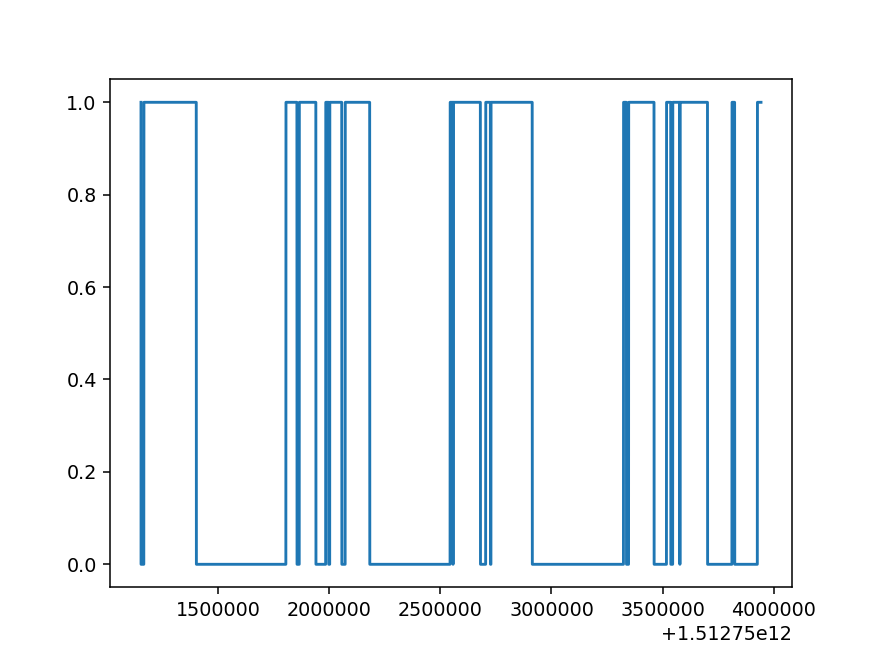

<IPython.core.display.Javascript object>


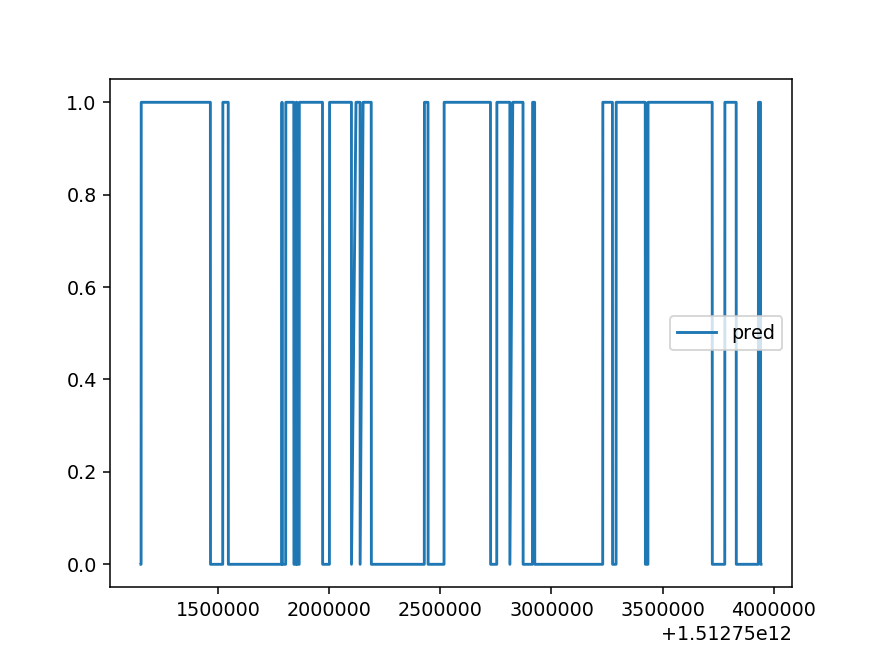

In [86]:
plt.figure()
plt.plot(time_t, y_true, label="true")
plt.figure()
plt.plot(time_t, smooth_labels_3, label="pred")

plt.legend()
plt.show()


In [25]:
cf_matrix = confusion_matrix(y_true, smooth_labels)
print(cf_matrix)
class_wise_f1 = np.round(f1_score(y_true, smooth_labels, average=None)*100)*0.01
print('the mean-f1 score: {:.2f}'.format(np.mean(class_wise_f1)))

[[5172 2367]
 [ 528 5321]]
the mean-f1 score: 0.79


In [ ]:
# to print start and end time


In [ ]:
#LSTM
[[5603 1936]
 [1599 4250]]
the mean-f1 score: 0.73
    
#CNN
[[6225 1314]
 [1883 3966]]
the mean-f1 score: 0.76
    
#Conv_LSTM_100
[[6551  988]
 [2105 3744]]
the mean-f1 score: 0.76
    
#Conv_LSTM
[[5553 1986]
 [1405 4444]]
the mean-f1 score: 0.74
    
#Convbn_100
[[6753  786]
 [2372 3477]]
the mean-f1 score: 0.75
    
#Convbn_LSTM_100
[[6612  927]
 [2265 3584]]
the mean-f1 score: 0.75